In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances, jensen_shannon_divergence

from general_tools.strings import trim_content_after_last_dot

from general_tools.plotting import stack_images_in_square_grid

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
seed = 42
np.random.seed(seed)

In [ ]:
# Load Ground-Truth Data
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/gt_all_chair.npz'
gt_data = np.load(in_f)
gt_data = gt_data[gt_data.keys()[0]]
_, gt_grid_var = entropy_of_occupancy_grid(gt_data, 32)

In [20]:
# LOAD (Synthetic) Point-Cloud Data


look_only = 1000 # speed up
# look_only = len(syn_data)

exp_name = 'ae_emd_1c_gan_chair_2048_pts_epoch_14'
exp_name = 'ae_trained_200eps_ae_emd_1c_gan_chair_2048_pts_epoch_20'
exp_name = 'ae_trained_200eps_512gen_ae_emd_1c_gan_chair_2048_pts_epoch_7'
exp_name = 'raw_gan_chair_2048_pts_epoch_40'

in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'
in_f = osp.join(in_f, exp_name + '.npz')
# in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/mit_3dgan_1K_synthetic_samples/point_clouds/2048/chair.npz'

save_figs = False
top_fig_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/Images/'

syn_data = np.load(in_f)
syn_data = syn_data[syn_data.keys()[0]]
syn_data = syn_data[:look_only]

In [30]:
create_dir('images_' + exp_name)
size = 100
rids = np.random.choice(range(len(syn_data)), size=size, replace=False)
plt.ioff()

for i in range(size):
    fig = Point_Cloud(syn_data[rids[i]]).plot(show=False, show_axis=False, azim=290, in_u_sphere=True, s=20);
    fig.savefig(osp.join('images_' + exp_name, 'sample_' +str(i)))
    plt.close()    

In [31]:
file_names = glob.glob('images_' + exp_name +'/*.png')
stack_images_in_square_grid(file_names, save_file= exp_name + '_BIG.png')

<PIL.Image.Image image mode=RGB size=6000x4000 at 0x7FBD191A1D88>

In [15]:
skata = np.zeros_like(syn_data)
for i, pc in enumerate(syn_data): # in u sphere
    skata[i] = Point_Cloud(pc).center_in_unit_sphere().points

In [6]:
# for i, pc in enumerate(syn_data):
#     syn_data[i] = Point_Cloud(pc).center_in_unit_sphere().points
#     temp = syn_data[i]
#     syn_data[i] = temp[:, [0,2,1]]
#     syn_data[i] = syn_data[i]

AssertionError: 

In [16]:
session = tf.Session()
distance_type = 'EMD'
all_dists = point_cloud_distances(skata, 10, session, distance_type)

214.547


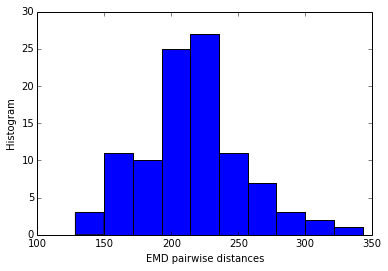

In [17]:
print np.mean(all_dists)
plt.hist(all_dists)[2]
plt.xlabel(distance_type + ' pairwise distances')
plt.ylabel('Histogram')
if save_figs:
    plt.savefig(trim_content_after_last_dot(in_f) + '_dist_hist.png')

In [18]:
mentropy, grid_var = entropy_of_occupancy_grid(skata, 32)
print mentropy

0.0443906329338


In [19]:
jensen_shannon_divergence(grid_var, gt_grid_var)

0.2393559747774659